# RL Figure: 2D-Turb-Time + Filters

In [3]:
using JLD2, Interpolations, Statistics, ForwardDiff, OrdinaryDiffEq

const n = 512 # grid resolution 
const L = 2π  # domain length    
const t_step = 0.005 # time-step of DNS data
const frame_max=1230 # number of frames         

##### Load Velocity Field #####
file = jldopen("../../Data Generation/2d-turb-data.jld")
u_data = file["vel_x"]
v_data = file["vel_y"]
vort_data = file["vort"]
close(file)

##### Interpolations #####
itp_vort = interpolate(vort_data, BSpline(Linear(Periodic())))
itp_u = interpolate(u_data, BSpline(Linear(Periodic())))
itp_v = interpolate(v_data, BSpline(Linear(Periodic())))

etp_vort = extrapolate(itp_vort, Periodic())
etp_u = extrapolate(itp_u, Periodic())
etp_v = extrapolate(itp_v, Periodic())

function vort(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_vort(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

function velX(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_u(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

function velY(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_v(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

N_tile = 30 
δ = L/N_tile # grid size for tiling

xA = 1.4 # start point
yA = 3.0 
rA = 0.2

xB = 5.2 # finish point
yB = 1.8
rB = 0.2

u0 = maximum(sqrt.(u_data[:,:,1].^2+v_data[:,:,1].^2)) # background maximum velocity
Va = 0.3*u0 # agent's velocity
Δt = δ/(2*u0) # agent's reaction time
Na = 8 # number of actions

n_episodes = 5000 # number of episodes for evaluation
n_train = 100000 # number of episodes for training

T_free = sqrt((xB-xA)^2+(yB-yA)^2)/Va
T_max = 5*T_free

w_reward = 1.0 # weight in the reward function

# optimal trajectory

##### Derivatives #####
velX_x(x,y,t) = ForwardDiff.derivative(z -> velX(z, y, t), x)
velX_y(x,y,t) = ForwardDiff.derivative(z -> velX(x, z, t), y)
velY_x(x,y,t) = ForwardDiff.derivative(z -> velY(z, y, t), x)
velY_y(x,y,t) = ForwardDiff.derivative(z -> velY(x, z, t), y)

function TURB_advection!(du, u, p, t)
    x, y, z = u
    T = p[2]
    du[1] = dx = T*velX(x,y,t*T) + Va*T*cos(z)
    du[2] = dy = T*velY(x,y,t*T) + Va*T*sin(z)
    du[3] = dz = T*(velY_x(x,y,t*T)*sin(z)*sin(z) - velX_y(x,y,t*T)*cos(z)*cos(z) + sin(z)*cos(z)*(velX_x(x,y,t*T)-velY_y(x,y,t*T)))
end

# Simulation interval and intermediary points
tspan = (0.0, 1.0)
tsteps = 0.0:0.001:1.0

p_opt = [-0.06496772807377783, 0.7000008854088864]
prob_opt = ODEProblem(TURB_advection!, [xA, yA, p_opt[1]], tspan, p_opt)
opt_solution = solve(prob_opt, p = p_opt, saveat = tsteps, reltol = 1e-16, abstol = 1e-16)

# points for optimal track
x_opt = []
y_opt = []

T = p_opt[2]

for i in 0:floor(Int, T/Δt)
    x_now, y_now = opt_solution(i*Δt/T)[1], opt_solution(i*Δt/T)[2]
    push!(x_opt, x_now)
    push!(y_opt, y_now)
end

nothing

In [4]:
##### Load Filtered Velocity Field #####
file_filt_10 = jldopen("../../Data Generation/2d-turb-data-filter-k10.jld")
u_data_filt_10 = file_filt_10["vel_x"][:,:,200]
v_data_filt_10 = file_filt_10["vel_y"][:,:,200]
vort_data_filt_10 = file_filt_10["vort"][:,:,200]
close(file_filt_10)

itp_vort_filt_10 = interpolate(vort_data_filt_10, BSpline(Linear(Periodic())))
itp_u_filt_10 = interpolate(u_data_filt_10, BSpline(Linear(Periodic())))
itp_v_filt_10 = interpolate(v_data_filt_10, BSpline(Linear(Periodic())))

etp_vort_filt_10 = extrapolate(itp_vort_filt_10, Periodic())
etp_u_filt_10 = extrapolate(itp_u_filt_10, Periodic())
etp_v_filt_10 = extrapolate(itp_v_filt_10, Periodic())

vort_filt_10(x,y) = etp_vort_filt_10(n*x/L+1, n*y/L+1)
velX_filt_10(x,y) = etp_u_filt_10(n*x/L+1, n*y/L+1)
velY_filt_10(x,y) = etp_v_filt_10(n*x/L+1, n*y/L+1)

#############

file_filt_5 = jldopen("../../Data Generation/2d-turb-data-filter-k5.jld")
u_data_filt_5 = file_filt_5["vel_x"][:,:,200]
v_data_filt_5 = file_filt_5["vel_y"][:,:,200]
vort_data_filt_5 = file_filt_5["vort"][:,:,200]
close(file_filt_5)

itp_vort_filt_5 = interpolate(vort_data_filt_5, BSpline(Linear(Periodic())))
itp_u_filt_5 = interpolate(u_data_filt_5, BSpline(Linear(Periodic())))
itp_v_filt_5 = interpolate(v_data_filt_5, BSpline(Linear(Periodic())))

etp_vort_filt_5 = extrapolate(itp_vort_filt_5, Periodic())
etp_u_filt_5 = extrapolate(itp_u_filt_5, Periodic())
etp_v_filt_5 = extrapolate(itp_v_filt_5, Periodic())

vort_filt_5(x,y) = etp_vort_filt_5(n*x/L+1, n*y/L+1)
velX_filt_5(x,y) = etp_u_filt_5(n*x/L+1, n*y/L+1)
velY_filt_5(x,y) = etp_v_filt_5(n*x/L+1, n*y/L+1)

#############

file_filt_3 = jldopen("../../Data Generation/2d-turb-data-filter-k3.jld")
u_data_filt_3 = file_filt_3["vel_x"][:,:,200]
v_data_filt_3 = file_filt_3["vel_y"][:,:,200]
vort_data_filt_3 = file_filt_3["vort"][:,:,200]
close(file_filt_3)

itp_vort_filt_3 = interpolate(vort_data_filt_3, BSpline(Linear(Periodic())))
itp_u_filt_3 = interpolate(u_data_filt_3, BSpline(Linear(Periodic())))
itp_v_filt_3 = interpolate(v_data_filt_3, BSpline(Linear(Periodic())))

etp_vort_filt_3 = extrapolate(itp_vort_filt_3, Periodic())
etp_u_filt_3 = extrapolate(itp_u_filt_3, Periodic())
etp_v_filt_3 = extrapolate(itp_v_filt_3, Periodic())

vort_filt_3(x,y) = etp_vort_filt_3(n*x/L+1, n*y/L+1)
velX_filt_3(x,y) = etp_u_filt_3(n*x/L+1, n*y/L+1)
velY_filt_3(x,y) = etp_v_filt_3(n*x/L+1, n*y/L+1)

#############

file_filt_2 = jldopen("../../Data Generation/2d-turb-data-filter-k2.jld")
u_data_filt_2 = file_filt_2["vel_x"][:,:,200]
v_data_filt_2 = file_filt_2["vel_y"][:,:,200]
vort_data_filt_2 = file_filt_2["vort"][:,:,200]
close(file_filt_2)

itp_vort_filt_2 = interpolate(vort_data_filt_2, BSpline(Linear(Periodic())))
itp_u_filt_2 = interpolate(u_data_filt_2, BSpline(Linear(Periodic())))
itp_v_filt_2 = interpolate(v_data_filt_2, BSpline(Linear(Periodic())))

etp_vort_filt_2 = extrapolate(itp_vort_filt_2, Periodic())
etp_u_filt_2 = extrapolate(itp_u_filt_2, Periodic())
etp_v_filt_2 = extrapolate(itp_v_filt_2, Periodic())

vort_filt_2(x,y) = etp_vort_filt_2(n*x/L+1, n*y/L+1)
velX_filt_2(x,y) = etp_u_filt_2(n*x/L+1, n*y/L+1)
velY_filt_2(x,y) = etp_v_filt_2(n*x/L+1, n*y/L+1)

nothing

In [5]:
# load data from files
using JLD2

q_data_10 = jldopen("../Q-learning/Q_data_time_filter_k10.jld2")
ac_data_10 = jldopen("../Actor-Critic/AC_data_time_filter_k10.jld2")

q_data_5 = jldopen("../Q-learning/Q_data_time_filter_k5.jld2")
ac_data_5 = jldopen("../Actor-Critic/AC_data_time_filter_k5.jld2")

q_data_3 = jldopen("../Q-learning/Q_data_time_filter_k3.jld2")
ac_data_3 = jldopen("../Actor-Critic/AC_data_time_filter_k3.jld2")

q_data_2 = jldopen("../Q-learning/Q_data_time_filter_k2.jld2")
ac_data_2 = jldopen("../Actor-Critic/AC_data_time_filter_k2.jld2")

nothing

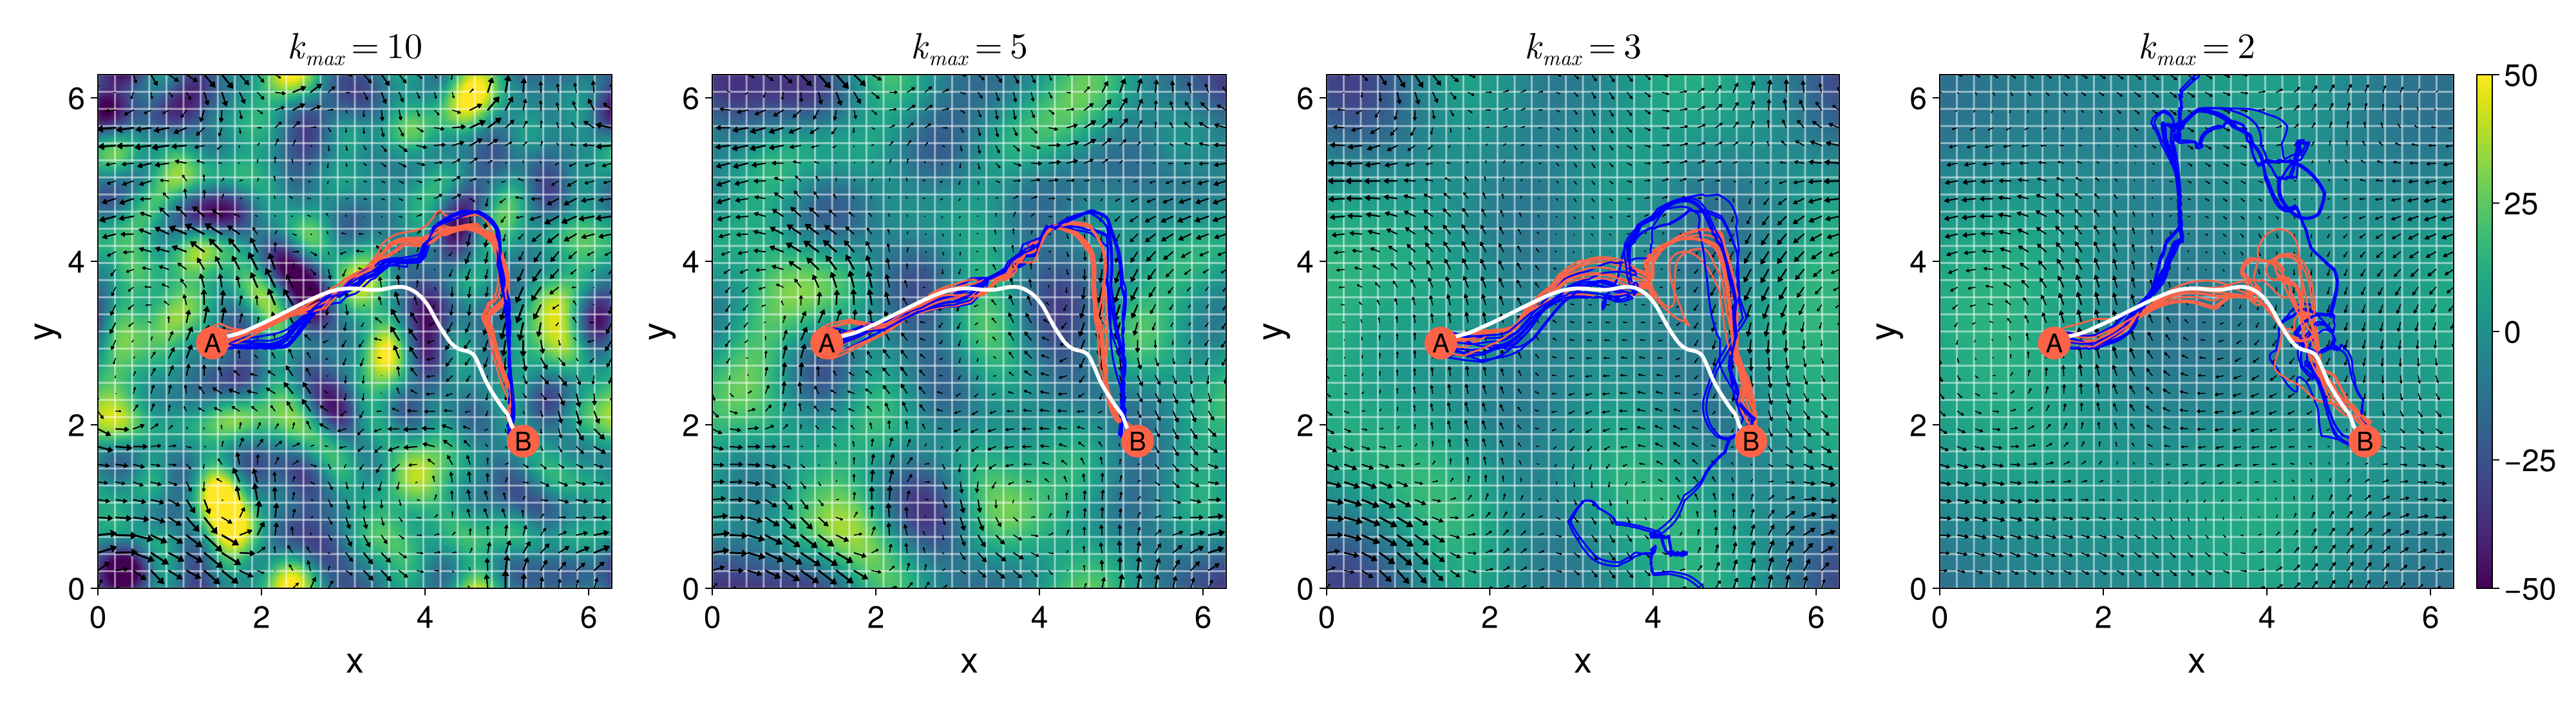

In [6]:
using CairoMakie, LaTeXStrings

fig = Figure(size = (2000, 550), fontsize=24)

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort_filt_10(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX_filt_10(x,y) for x in xs2, y in ys2]
vs2 = [velY_filt_10(x,y) for x in xs2, y in ys2]

ax1 = Axis(fig[1, 1], title=L"k_{max}=10", titlesize=28,
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, L), (0, L)), xticks=[0,2,4,6], yticks=[0,2,4,6]
)

hm = heatmap!(ax1, xs, ys, zs, colorrange=(-50, 50), colormap = :viridis, alpha=1.0)

hlines!(ax1, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax1, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax1, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax1, q_data_10["x_tracks_EV"][i], q_data_10["y_tracks_EV"][i], color=:tomato)
    lines!(ax1, ac_data_10["x_tracks_EV"][i], ac_data_10["y_tracks_EV"][i], color=:blue)
end

lines!(ax1, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax1, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax1, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

####################################

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort_filt_5(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX_filt_5(x,y) for x in xs2, y in ys2]
vs2 = [velY_filt_5(x,y) for x in xs2, y in ys2]

ax2 = Axis(fig[1, 2], title=L"k_{max}=5", titlesize=28,
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, L), (0, L)), xticks=[0,2,4,6], yticks=[0,2,4,6]
)

hm = heatmap!(ax2, xs, ys, zs, colorrange=(-50, 50), colormap = :viridis, alpha=1.0)

hlines!(ax2, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax2, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax2, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax2, q_data_5["x_tracks_EV"][i], q_data_5["y_tracks_EV"][i], color=:tomato)
    lines!(ax2, ac_data_5["x_tracks_EV"][i], ac_data_5["y_tracks_EV"][i], color=:blue)
end

lines!(ax2, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax2, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax2, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

####################################

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort_filt_3(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX_filt_3(x,y) for x in xs2, y in ys2]
vs2 = [velY_filt_3(x,y) for x in xs2, y in ys2]

ax3 = Axis(fig[1, 3], title=L"k_{max}=3", titlesize=28,
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, L), (0, L)), xticks=[0,2,4,6], yticks=[0,2,4,6]
)

hm = heatmap!(ax3, xs, ys, zs, colorrange=(-50, 50), colormap = :viridis, alpha=1.0)

hlines!(ax3, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax3, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax3, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax3, q_data_3["x_tracks_EV"][i], q_data_3["y_tracks_EV"][i], color=:tomato)
    lines!(ax3, ac_data_3["x_tracks_EV"][i], ac_data_3["y_tracks_EV"][i], color=:blue)
end

lines!(ax3, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax3, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax3, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

####################################

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort_filt_2(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX_filt_2(x,y) for x in xs2, y in ys2]
vs2 = [velY_filt_2(x,y) for x in xs2, y in ys2]

ax4 = Axis(fig[1, 4], title=L"k_{max}=2", titlesize=28,
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, L), (0, L)), xticks=[0,2,4,6], yticks=[0,2,4,6]
)

hm = heatmap!(ax4, xs, ys, zs, colorrange=(-50, 50), colormap = :viridis, alpha=1.0)
Colorbar(fig[1, 5], hm, ticklabelsize=24, tellheight=true, ticks=[-50,-25,0,25,50])

rowsize!(fig.layout, 1, ax4.scene.viewport[].widths[2])

hlines!(ax4, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax4, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax4, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax4, q_data_2["x_tracks_EV"][i], q_data_2["y_tracks_EV"][i], color=:tomato)
    lines!(ax4, ac_data_2["x_tracks_EV"][i], ac_data_2["y_tracks_EV"][i], color=:blue)
end

lines!(ax4, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax4, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax4, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

####################################

save("RL_2d_turb_time_filt.pdf", fig)
fig

### Collected Statistics

In [16]:
using Plots, Statistics, LaTeXStrings

#alpha=0.04
Q_256_T = [0.9350158014907815, 0.9506153499303839, 0.9413203620755608, 0.9634094459826275, 2.170060890908047, 
            3.2341551494815532, 0.996672694393593, 0.9394916331217628, 0.9394804225228119, 0.9415697979022094]
Q_256_fail = [0, 0, 0, 0, 0.7616, 0.6941999999999999, 0, 0, 0, 0]
Q_256_p = ones(10).-Q_256_fail
Q_256_g = Q_256_p./sum(Q_256_p)

Q_10_T = [0.9311047037819306, 0.9223982723720073, 0.9445686331214649, 0.9710971142129246, 2.659718288700119, 
            3.358761093217487, 0.8945483419292596, 0.9399134319072747, 0.9393388887110623, 3.37103777335634]
Q_10_fail = [0, 0, 0, 0, 0.62, 0.9778, 0, 0, 0, 0.8634]
Q_10_p = ones(10).-Q_10_fail
Q_10_g = Q_10_p./sum(Q_10_p)

Q_5_T = [0.9915284308001879, 0.9983066391906265, 1.001393757876617, 0.96332396516563, 1.0947906590579937, 
            3.3986583791617715, 3.3157278744077217, 0.9610944572993518, 1.3655224158308938, 0.9606670532143645]
Q_5_fail = [0, 0, 0, 0, 0, 0.8742, 0.43579999999999997, 0, 0.06740000000000002, 0]
Q_5_p = ones(10).-Q_5_fail
Q_5_g = Q_5_p./sum(Q_5_p)

Q_3_T = [0.9941956785161559, 0.9223730485243686, 0.9682753467742587, 3.7564264764562303, 3.8194048331569777, 
            0.9308818931277887, 1.1460342847025122, 0.9094892676805213, 2.9300664988414673, 1.9854629845205403]
Q_3_fail = [0.04820000000000002, 0, 0.03639999999999999, 0.9984, 0.9806, 0, 0.2158, 0, 0.973, 0.8078]
Q_3_p = ones(10).-Q_3_fail
Q_3_g = Q_3_p./sum(Q_3_p)

Q_2_T = [1.3370552001502096, 1.102018082630697, 1.127201997968003, 1.1207740540636257, 1.3872713810741575,
            1.030751513878205, 1.0557301296647588, 1.1302862179849744, 1.0952799571924856, 2.0373257168108676]
Q_2_fail = [0.038799999999999946, 0.00039999999999995595, 0.19440000000000002, 0.0048000000000000265, 0.1642,
            0, 0, 0, 0.0026000000000000467, 0.6466000000000001]
Q_2_p = ones(10).-Q_2_fail
Q_2_g = Q_2_p./sum(Q_2_p)

#alpha=0.01
Q2_256_T = [1.0064090995820911, 0.9391665257521985, 0.9947767018460918, 0.9333561165685254, 1.035307137222814,
            0.9483774341148928, 1.029452485724818, 0.9590751481633956, 0.9562963209485431, 0.9467645091908915]
Q2_256_fail = [0, 0, 0, 0.0006000000000000449, 0.0033999999999999586, 0, 0, 0, 0, 0]
Q2_256_p = ones(10).-Q2_256_fail
Q2_256_g = Q2_256_p./sum(Q2_256_p)

Q2_10_T = [0.9216849980137828, 0.9258931765948216, 0.9137408873324936, 0.9285248646984486, 0.9578531928777924,
            0.9187029786929531, 0.9118378881606485, 0.9256899844888441, 1.1107720358152913, 0.9329222221367774]
Q2_10_fail = [0, 0, 0, 0, 0, 0, 0, 0, 0.18600000000000005, 0]
Q2_10_p = ones(10).-Q2_10_fail
Q2_10_g = Q2_10_p./sum(Q2_10_p)

Q2_5_T = [0.9512501500959551, 1.026782961849733, 0.9484769281805784, 0.9979205672295155, 0.9494368357157138, 
            0.9653222544285545, 0.946680429698763, 0.9615051136492635, 0.9236594647539372, 1.0493125884694603]
Q2_5_fail = [0, 0, 0, 0.013399999999999967, 0, 0, 0, 0.01319999999999999, 0, 0.042200000000000015]
Q2_5_p = ones(10).-Q2_5_fail
Q2_5_g = Q2_5_p./sum(Q2_5_p)

Q2_3_T = [1.3429835105476984, 1.2020784727881657, 1.071769878281152, 1.0381006989768973, 1.139001975216583, 
            1.2960745370926103, 1.1775276819623268, 1.0006496543712782, 1.023412070076557, 1.3327775019936254]
Q2_3_fail = [0, 0.0038000000000000256, 0.2178, 0.11939999999999995, 0.10260000000000002, 0.053200000000000025,
             0, 0, 0.12439999999999996, 0.06540000000000001]
Q2_3_p = ones(10).-Q2_3_fail
Q2_3_g = Q2_3_p./sum(Q2_3_p)

Q2_2_T = [0.9396892199282655, 1.1048073292202538, 1.0402819243109875, 1.0924406372529976, 1.0677765345265284,
            1.0481625032752373, 1.0939916524636517, 1.1241582243336634, 1.093673803137552, 1.057994042300681]
Q2_2_fail = [0, 0, 0, 0, 0.006800000000000028, 0.02639999999999998, 0.0011999999999999789, 0, 0, 0.3256]
Q2_2_p = ones(10).-Q2_2_fail
Q2_2_g = Q2_2_p./sum(Q2_2_p)

#########################

kf = 5.5
k_max = [256, 10, 5, 3, 2]

nothing

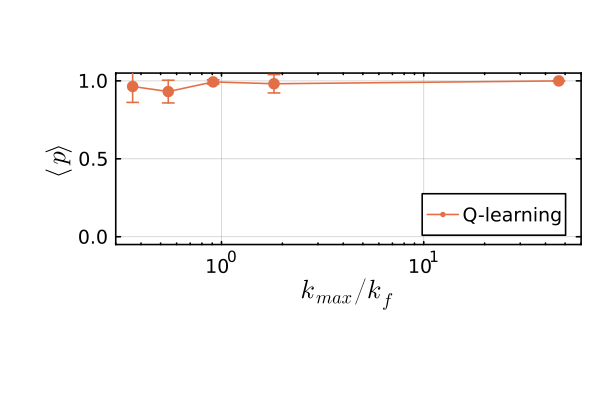

In [17]:
x_vals = k_max./kf
y_q_vals = [mean(Q_256_p), mean(Q_10_p), mean(Q_5_p), mean(Q_3_p), mean(Q_2_p)]
y_q_err = [std(Q_256_p), std(Q_10_p), std(Q_5_p), std(Q_3_p), std(Q_2_p)]

y2_q_vals = [mean(Q2_256_p), mean(Q2_10_p), mean(Q2_5_p), mean(Q2_3_p), mean(Q2_2_p)]
y2_q_err = [std(Q2_256_p), std(Q2_10_p), std(Q2_5_p), std(Q2_3_p), std(Q2_2_p)]

#y_ac_vals = [mean(AC_256_p), mean(AC_10_p), mean(AC_5_p), mean(AC_3_p), mean(AC_2_p)]
#y_ac_err = [std(AC_256_p), std(AC_10_p), std(AC_5_p), std(AC_3_p), std(AC_2_p)]

plot(x_vals, y2_q_vals, yerr=y2_q_err, xaxis=:log10, lc=2, framestyle=:box, xlim=(0.3, 60), ylim=(-0.05,1.05), legend=:bottomright, label="Q-learning", xminorticks=9,
        xlabel=L"k_{max}/k_f", ylabel=L"\langle p \rangle", aspect_ratio=20, yticks=[0,0.5,1], marker=:circle, mc=2, msc=2, thickness_scaling=1.6)

#plot!(x_vals, y2_q_vals, yerr=y2_q_err, lc=3, label="Q2-learning", marker=:diamond, mc=3, ls=:dash, msc=3)

#p1 = plot!(x_vals, y_ac_vals, yerr=y_ac_err, lc=1, label="Actor-Critic", marker=:diamond, mc=1, ls=:dash, msc=1)

#savefig(p1, "success2.svg")

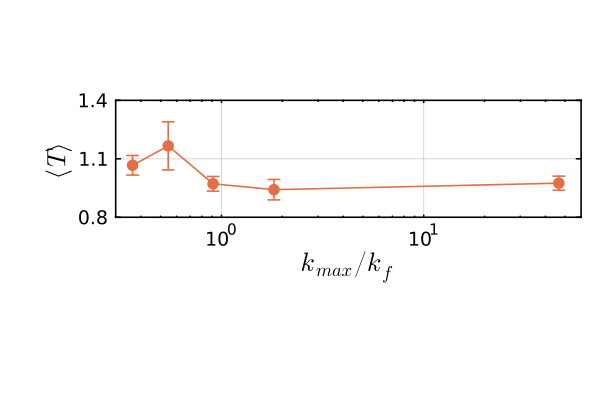

In [18]:
y_q_vals = [sum(Q_256_g.*Q_256_T), sum(Q_10_g.*Q_10_T), sum(Q_5_g.*Q_5_T), sum(Q_3_g.*Q_3_T), sum(Q_2_g.*Q_2_T)]
y_q_var = [sum(Q_256_g.*(Q_256_T.-y_q_vals[1]).^2), sum(Q_10_g.*(Q_10_T.-y_q_vals[2]).^2), sum(Q_5_g.*(Q_5_T.-y_q_vals[3]).^2),
             sum(Q_3_g.*(Q_3_T.-y_q_vals[4]).^2), sum(Q_2_g.*(Q_2_T.-y_q_vals[5]).^2)]

y2_q_vals = [sum(Q2_256_g.*Q2_256_T), sum(Q2_10_g.*Q2_10_T), sum(Q2_5_g.*Q2_5_T), sum(Q2_3_g.*Q2_3_T), sum(Q2_2_g.*Q2_2_T)]
y2_q_var = [sum(Q2_256_g.*(Q2_256_T.-y2_q_vals[1]).^2), sum(Q2_10_g.*(Q2_10_T.-y2_q_vals[2]).^2), sum(Q2_5_g.*(Q2_5_T.-y2_q_vals[3]).^2),
             sum(Q2_3_g.*(Q2_3_T.-y2_q_vals[4]).^2), sum(Q2_2_g.*(Q2_2_T.-y2_q_vals[5]).^2)]

#y_ac_vals = [sum(AC_256_g.*AC_256_T), sum(AC_10_g.*AC_10_T), sum(AC_5_g.*AC_5_T), sum(AC_3_g.*AC_3_T), sum(AC_2_g.*AC_2_T)]
#y_ac_var = [sum(AC_256_g.*(AC_256_T.-y_ac_vals[1]).^2), sum(AC_10_g.*(AC_10_T.-y_ac_vals[2]).^2), sum(AC_5_g.*(AC_5_T.-y_ac_vals[3]).^2), 
#                sum(AC_3_g.*(AC_3_T.-y_ac_vals[4]).^2), sum(AC_2_g.*(AC_2_T.-y_ac_vals[5]).^2)]

plot(x_vals, y2_q_vals, yerr=sqrt.(y2_q_var), xaxis=:log10, lc=2, framestyle=:box, xlim=(0.3, 60), ylim=(0.8, 1.4), label="Q-learning", xminorticks=9,
        xlabel=L"k_{max}/k_f", ylabel=L"\langle T \rangle", marker=:circle, mc=2, msc=2, thickness_scaling=1.6, aspect_ratio=25, yticks=[0.8,1.1,1.4], legend=false)

#plot!(x_vals, y2_q_vals, yerr=sqrt.(y2_q_var), lc=3, label="Q2-learning", marker=:diamond, mc=3, ls=:dash, msc=3)

#p2=plot!(x_vals, y_ac_vals, yerr=sqrt.(y_ac_var), lc=1, label="Actor-Critic", marker=:diamond, mc=1, ls=:dash, msc=1)

#savefig(p2, "time2.svg")